# Tarea 6

Métodos Computacionales, 2015-19

Sebastián Camilo Puerto, 201318518

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Punto 1: Cálculo Simbólico

Uso de `Sympy` para calcular las ecuaciones que definen a los métodos multisteps explícitos de Adams-Bashford.

In [2]:
from sympy import *

init_printing(use_unicode = True)  # Para que utilice los caracteres de Unicode para renderizar bonito

### a)

Función para cálculo de los polinomios de Lagrange simbólicos de n puntos.

In [3]:
def lagrange(n):
    
    var('t')  #t como símbolo, que utilizo tal como se renderiza
    
    # Definir los t's y f's para utilizar como símbolos
    for i in range(n):
        exec("t_" + str(i) + ", f_" + str(i) + " = symbols('t_{" + str(i) + "}, f_{" + str(i) + "}')")
    
    polinomio = Float(0)
    
    # Hacer polinomio
    for i in range(n):
        
        # Hacer monomios  
        termino = eval("f_" + str(i))
        for j in range(n):      
            if i != j:
                termino *= eval("(t - t_" + str(j) + ")/(t_" + str(i) + " - t_" + str(j) + ")")
        
        polinomio += termino
        
    return polinomio

### b)  
Función para Adams-Bashford de orden $m$, para hallar el vector estado en $t_m$, teniendo el valor de la derivada en los $m$ puntos anteriores, denotados por $t_i = t_m - i*h$, con valores $f_i = f(t_i)$.



In [4]:
def adams(m):
    
    # Hallar polinomio base
    polinomio = lagrange(m)
    
    # Definir los t's y f's para utilizar como símbolos
    for i in range(m):
        exec("t_" + str(i) + " = symbols('t_{" + str(i) + "}')")
        
    # Redefinir símbolos en terminos de t_{n-1} y h
    tn1, h = symbols('t_{n-1}, h')
    
    for i in range(0, m):
        polinomio = polinomio.subs(eval('t_' + str(m-1 - i)), tn1 - i*h)
    
    # Integrar para hallar la diferencia del vector estado para t_n
    return simplify(integrate(polinomio, (t, tn1, tn1 + h)))
    

## Punto 2: Ecuación de Poisson para el Potencial Gravitacional



Se estudia el potencial gravitacional generado por un cubo maciso.

Se utiliza un método de relajación para resolver la ecuación de Poisson $\nabla \Phi = f$, la cual en nuestro caso se traduce a $\frac{\partial^2 \Phi}{\partial x^2} + \frac{\partial^2 \Phi}{\partial y^2} + \frac{\partial^2 \Phi}{\partial z^2} = 4\pi G\rho$, donde $\rho$ representa la densidad de masa.

Aproximaremos el espacio con una cuadrícula simétrica finita, en la cual es posible utilizar la aproximación de las segundas derivadas de la siguiente forma: $\frac{\partial^2 \Phi}{\partial x^2} = \frac{\Phi(x + h, \cdots) + \Phi(x - h, \cdots) - 2\Phi(x, \cdots)}{h^2}$, de donde se deduce una fórmula iterativa para el potencial, dado por:

$\Phi(x,\cdots) = \frac{-4\pi G\rho + \Phi(x + h, \ldots) + \Phi(x - h, \ldots) + \Phi(y + h, \ldots) + \Phi(y - h, \ldots) + \Phi(z + h, \ldots) + \Phi(z - h, \ldots)}{6}$

In [5]:
# Unidades SI

# Valores particulares

G = 6.67384E-11                
L = 3000.                            # Lado de un cubo que representa el espacio
l = 270.                             # Lado del cubo maciso
rho = 400.                           # Densidad

h = 30.                              # Lado de un cubo de la cuadrícula
N = int(round((L + h) / h, 0) + .1)  # Número de cubos que componen la cuadrícula

masa = rho * l**3                    # Masa del cubo

rhs = 4 * np.pi * G                  # RHS de la ecuación de Poisson

# Límites del cubo que representa el espacio
x_min = y_min = z_min = -L/2 
x_max = y_max = z_max =  L/2

# Ticks de los ejes, centrados en los cuadros que componen la cuadrícula
## que discretiza el espacio representado. Esto resulta en un largo 
## del espacio mayor al dicho en h metros, pues cada tick lleva al centro
## de un cubo de la cuadrícula, pero de esta forma se puede
## acomodar exactamente el cubo macizo dentro de la cuadrícula, que parece
## asumirse para el siguiente punto. Si en cambio hago el largo exactamente 
## L, toca o correr el cubo, o cambiarlo de tamaño, y esto dañó en algo
## los resultados.
x_tick = np.linspace(x_min, x_max, N)
y_tick = np.linspace(y_min, y_max, N)
z_tick = np.linspace(z_min, z_max, N)

i_ctro = int(round(N / 2, 0) + .1)  # Índice del origen, también centro del cubo macizo

# Meshgrid para las coordenadas del espacio.
# La forma en que lo escribí permite cambiar a un paralelepípedo sin
## dolores de cabeza (por alguna razón no es intuitivo el meshgrid).
y_mesh, x_mesh, z_mesh = np.meshgrid(y_tick, x_tick, z_tick) # Sólo así me funcionó

# Potencial (phi) de masa puntual centrada como ansatz
## Como numpy soporta -inf y estoy tratando con ndarrays, no me preocupo
### por la división en 0 que surge 
phi = (-G * masa / np.sqrt(x_mesh**2 + y_mesh**2 + z_mesh**2))# + 1.E-10))
phi[i_ctro, i_ctro, i_ctro] = phi[i_ctro, i_ctro, i_ctro + 1]

# No realmente necesario en este caso, pero fuerzo las condiciones de rontera
phi[0] = 0.
phi[-1] = 0.
phi[:, 0, :] = 0.
phi[:, -1, :] = 0.
phi[:, :, 0] = 0.
phi[:, :, -1] = 0.

# Distribución de densidad de la masa que genear el campo gravitacional.
## Cubo de lado l, centrado en el origen
densidad = np.ones((N, N, N)) * rho
densidad[np.abs(x_mesh) > l/2.] *= 0
densidad[abs(y_mesh) > l/2.] *= 0
densidad[abs(z_mesh) > l/2.] *= 0

/home/cohnan/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide


In [6]:
# Resolución de la ecuación

iteraciones = 5000

for i in range(iteraciones):
    phi = (- rhs * densidad * h**2 + 
           np.roll(phi, 1, axis = 0) + np.roll(phi, -1, axis = 0) + # x
           np.roll(phi, 1, axis = 1) + np.roll(phi, -1, axis = 1) + # y
           np.roll(phi, 1, axis = 2) + np.roll(phi, -1, axis = 2)   # z
          ) / 6.
    
    # Condiciones de frontera
    phi[0] = 0.
    phi[-1] = 0.
    phi[:, 0, :] = 0.
    phi[:, -1, :] = 0.
    phi[:, :, 0] = 0.
    phi[:, :, -1] = 0.

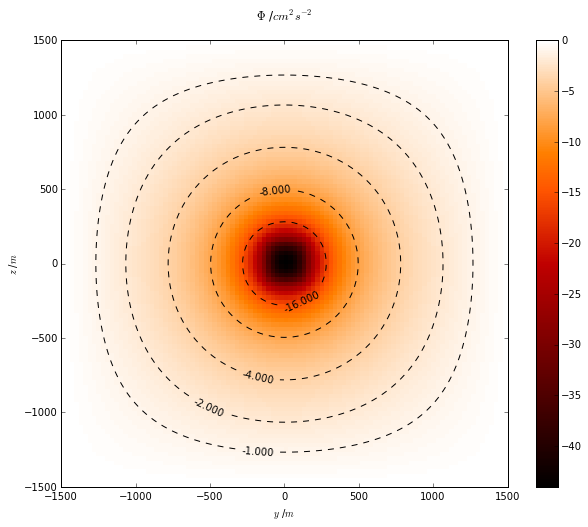

In [7]:
fig_1 = plt.figure('Potencial Gravitacional', figsize=(10,8))
ax_11 = fig_1.add_subplot(111)

ax_11.set_title('$\Phi$ /$cm^{2}s^{-2}$\n')
ax_11.set_xlabel('$y$ /$m$')
ax_11.set_ylabel('$z$ /$m$')

## El factor ante el potencia se debe a un cambio de unidades de área a cm^2
fig_1.colorbar(ax_11.pcolor(y_tick, z_tick, 100**2 * phi[i_ctro], cmap='gist_heat'))
ax_11.clabel(ax_11.contour(y_tick, z_tick, 100**2 * phi[i_ctro], levels=[-1, -2, -4, -8, -16],colors = 'k'))

ax_11.set_xlim([-1500, 1500])
ax_11.set_ylim([-1500, 1500])

plt.show()

### b)

Gráfica del potencial grativacional a lo largo del eje z. Se compara visualmente con el generado por un látice de masas puntuales.

In [8]:
# Cálculo del potencial generado por 
# látice de masas puntuales en lugar del cubo macizo

phi_2 = np.zeros((N, N, N))

for i in range(-4, 5):
    for j in range(-4, 5):
        for k in range(-4, 5):
            phi_2 += - G * (h**3 * rho
                           ) / np.sqrt((x_mesh - i*h)**2 + (y_mesh - j*h)**2 + (z_mesh - k*h)**2)
            ## Cambio los infinitos por valores en un lugar cercano.
            phi_2[i_ctro + i, i_ctro + j, i_ctro + k] = phi_2[i_ctro + i, i_ctro + j, i_ctro + k + 1]

/home/cohnan/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


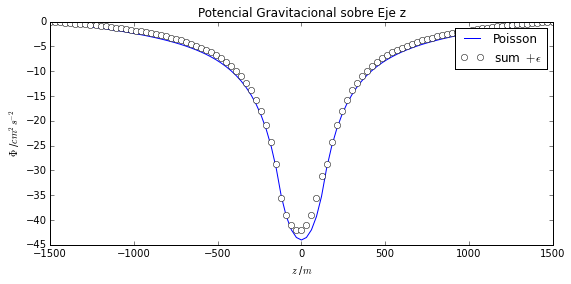

In [9]:
# Gráfica de los potenciales

fig_2 = plt.figure(u'Comparación Potencial', figsize=(9, 4))
ax_21 = fig_2.add_subplot(111)

ax_21.set_title('Potencial Gravitacional sobre Eje z')
ax_21.set_xlabel('$z$ /$m$')
ax_21.set_ylabel('$\Phi$ /$cm^{2}s^{-2}$')

ax_21.plot(z_tick, 100**2 * phi  [i_ctro, i_ctro], label = "Poisson")
ax_21.plot(z_tick, 100**2 * (phi_2[i_ctro, i_ctro] - phi_2[i_ctro, i_ctro, 0]),
           'wo', label='sum $+\epsilon$') # Constante tal que en los extremos sea 0

ax_21.legend()
plt.show()

### c)

Obtención del campo gravitacional a lo largo del eje z, mediante integración numérica (diferencias centrales) del potencial.

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:476: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


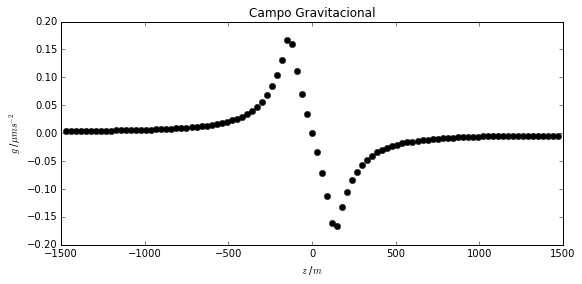

In [10]:
## Array del potencial a lo largo del eje z, en cgs
potencial_z = 100**2 * phi[i_ctro, i_ctro]

derivadas = (np.roll(potencial_z, 1) - np.roll(potencial_z, -1)
           ) / (2 * h)
fig_3 = plt.figure('Campo Gravitacional', figsize=(9,4))
ax_31 = fig_3.add_subplot(111)

ax_31.set_title('Campo Gravitacional')
ax_31.set_xlabel('$z$ /$m$')
ax_31.set_ylabel('$g$ /$\mu m s^{-2}$')

ax_31.plot(z_tick[1:-1], derivadas[1 : -1], 'ko')

ax_31.legend()
plt.show( )

### d)

Pequeña aplicación. Calculamos el tiempo que le toma a una partícula pequeña inicialmente en reposo, para recorrer $500m$ perpendiculares a una cara (en el eje z).

In [11]:
from scipy import interpolate

# SI units
# Variables
timestep = 0.2 #s
dif_dist = 0.1 #m
Y_0 = array([l/2. + 500., 0.]) # Sólo en z, cara superior

# Interpolación de la aceleración a lo largo del eje z.
## Asume simetría, y por lo tanto ignora el resto de coordenadas.
campo_grav_z = interpolate.interp1d(z_tick[1:-1], derivadas[1:-1] / 100**2)

## Función de derivada del vector estado
def fun_der(Y, t):
    return array([Y[1], campo_grav_z(Y[0])])

## Método de solución de la ecuación de movimiento
def runge_kutta_4th(fun_der, Y, t, timestep):

    k1 = fun_der(Y, t)
    k2 = fun_der(Y + timestep * k1 / 2., t + timestep / 2.)
    k3 = fun_der(Y + timestep * k2 / 2., t + timestep / 2.)
    k4 = fun_der(Y + timestep * k3, t + timestep)
    
    return Y + timestep*(k1/6. + k2/3. + k3/3. + k4/6.)

# Resolución de la ecuación.
Ys = [Y_0] # En caso de querer graficar
Y_act = Ys[0]
t = 0.

## Se avanza en el tiempo hasta que la partícula atraviese el cubo.
while Y_act[0] > l/2.:
    Y_act = runge_kutta_4th(fun_der, Y_act, t, timestep)
    Ys.append(Y_act)
    t += timestep

# Formato del tiempo e impresión del mismo.
horas = t // 3600 
minutos = (t - 3600 * horas) // 60
segundos = t - 3600 * horas - 60 * minutos

print "Tiempo:", horas, ":", minutos, ":", round(segundos, 0)

Tiempo: 6.0 : 26.0 : 42.0
